In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.models import TCNModel, RNNModel
from darts.utils.callbacks import TFMProgressBar
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [3]:
from darts.metrics import mape,rmse,mae

# 使用TCN模型预测太阳活动周强弱

## 加载数据集

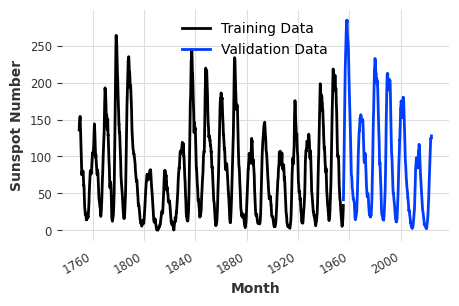

the 'monthly sunspots' dataset has 3293 data points


(3293, 2470, 823)

In [4]:
series = SunspotsDataset().load().astype(np.float32)
# check_seasonality(series, max_lag=240)

# train, val = series.split_after(pd.Timestamp("19560101"))
train, val = series.split_after(0.75)

plt.figure(figsize=(5, 3))
train.plot(label = "Training Data")
val.plot(label='Validation Data')
plt.ylabel('Sunspot Number')
plt.show()

scaler = Scaler()
train_scaled = scaler.fit_transform(train) #训练集
val_scaled = scaler.transform(val)       #测试集
series_scaled = scaler.transform(series) #全量数据

print("the 'monthly sunspots' dataset has {} data points".format(len(series_scaled)))
len(series_scaled),len(train_scaled),len(val_scaled)

## 模型创建与训练

In [4]:
input_chunk_length =  1200
output_chunk_length = 120

In [77]:
model_name = "TCN_sun_multi"
model = TCNModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
#     n_epochs=200,
    n_epochs=200,
    dropout=0.4,
    dilation_base=2,
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs()
)

model.fit(
    series = series_scaled,
#     series=train_scaled, 
#     val_series=val_scaled, 
    verbose=True
)

Training: 0it [00:00, ?it/s]

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=6, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.4, input_chunk_length=1200, output_chunk_length=120, n_epochs=300, nr_epochs_val_period=1, random_state=0, save_checkpoints=True, model_name=TCN_sun_multi, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000019F55B380D0>]})

In [78]:
# best_model = TCNModel.load_from_checkpoint(
#     model_name=model_name, best=True 
# )
best_model = model

## 回测—模型对整个数据集的拟合

MAE: 18.611687
RMSE: 24.736929


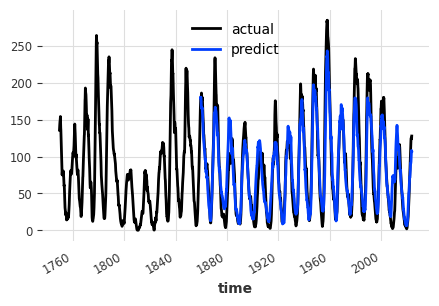

In [79]:
backtest = best_model.historical_forecasts(
    series=series_scaled,  # 输入整个序列
    forecast_horizon=output_chunk_length,  # 发出长度等于forecast_horizon的预测
    retrain=False,  # 是否重新训练模型
    verbose=True,  # 是否显示详细信息
)

plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_scaled).plot(label="actual")  # 绘制实际值
scaler.inverse_transform(backtest).plot(label="predict")  # 绘制Transformer模型预测值
plt.legend()  

print("MAE:", mae(scaler.inverse_transform(backtest), scaler.inverse_transform(series_scaled)))
print("RMSE:", rmse(scaler.inverse_transform(backtest), scaler.inverse_transform(series_scaled))) 

## 模型评估

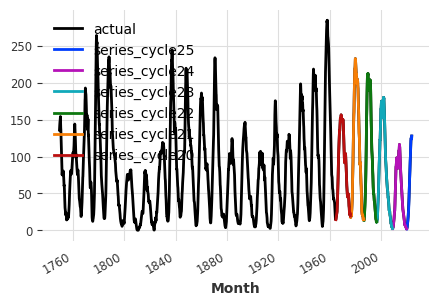

In [80]:
cycle20 = "19641001"         # "19641001" ,
cycle21 =  "19760301"        # "19760301",
cycle22 =  "19860901"        # "19860901",
cycle23 = "19960801"         #"19960801"
cycle24 = "20081201"         #"20081201"
cycle25 = "20191201"         #"20191201" 

before_series_cycle25, series_cycle25 = series_scaled.split_after(pd.Timestamp("20191101"))
before_series_cycle24, series_cycle24 = before_series_cycle25.split_after(pd.Timestamp("20081101"))
before_series_cycle23, series_cycle23 = before_series_cycle24.split_after(pd.Timestamp("19960701"))
before_series_cycle22, series_cycle22 = before_series_cycle23.split_after(pd.Timestamp("19860801"))
before_series_cycle21, series_cycle21 = before_series_cycle22.split_after(pd.Timestamp("19760201"))
before_series_cycle20, series_cycle20 = before_series_cycle21.split_after(pd.Timestamp("19640901"))

plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_scaled).plot(label="actual")  # 绘制实际值
scaler.inverse_transform(series_cycle25).plot(label="series_cycle25")  # 绘制实际值
scaler.inverse_transform(series_cycle24).plot(label="series_cycle24")  # 绘制实际值
scaler.inverse_transform(series_cycle23).plot(label="series_cycle23")  # 绘制实际值
scaler.inverse_transform(series_cycle22).plot(label="series_cycle22")  # 绘制实际值
scaler.inverse_transform(series_cycle21).plot(label="series_cycle21")  # 绘制实际值
scaler.inverse_transform(series_cycle20).plot(label="series_cycle20")  # 绘制实际值
plt.legend()

In [101]:
def eval_model(model,before_series,series,title):
    pred_series = model.predict(
        n=len(series),
        series = before_series
    )   
    
    series = scaler.inverse_transform(series)
    pred_series = scaler.inverse_transform(pred_series)
    plt.figure(figsize=(5, 3))
    
    print("两种数据的MAE：",mae(pred_series, series))
    print("两种数据的rmse：",rmse(pred_series, series))
    print(len(pred_series),len(series))
    
    series.plot(label="Actual")
    pred_series.plot(label="Predict")
    plt.title(title)
    plt.legend()
    plt.show()
    
    print(series.time_index[0], pred_series.time_index[0])

两种数据的MAE： 9.219488
两种数据的rmse： 12.137396
137 137


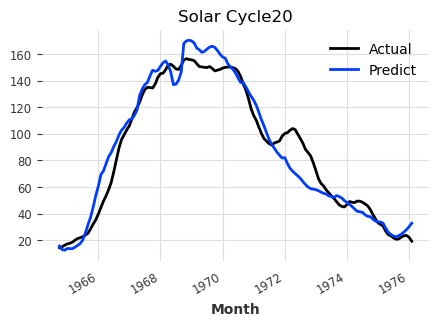

1964-10-01 00:00:00 1964-10-01 00:00:00


In [102]:
eval_model(best_model, before_series_cycle20,series_cycle20,"Solar Cycle20")

两种数据的MAE： 29.98937
两种数据的rmse： 36.77589
126 126


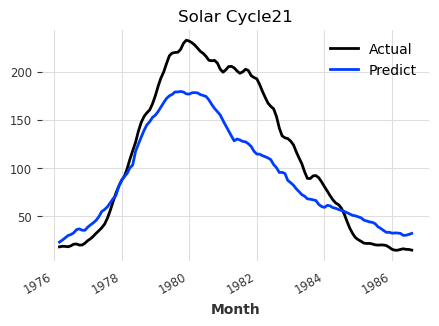

1976-03-01 00:00:00 1976-03-01 00:00:00


In [103]:
eval_model(best_model, before_series_cycle21,series_cycle21,"Solar Cycle21")

两种数据的MAE： 25.895002
两种数据的rmse： 28.644659
119 119


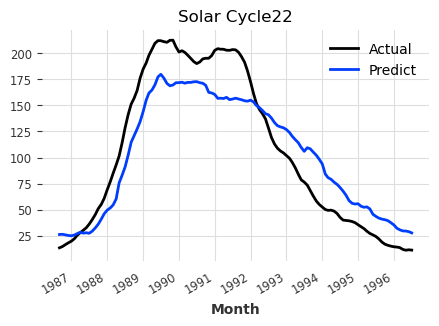

1986-09-01 00:00:00 1986-09-01 00:00:00


In [104]:
eval_model(best_model, before_series_cycle22,series_cycle22,"Solar Cycle22")

两种数据的MAE： 14.193441
两种数据的rmse： 19.105112
148 148


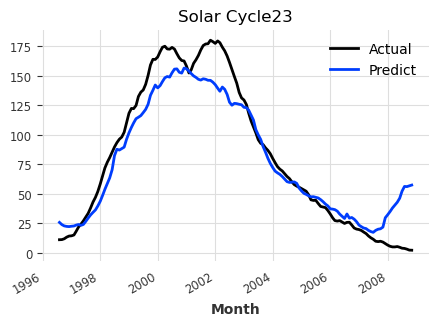

1996-08-01 00:00:00 1996-08-01 00:00:00


In [105]:
eval_model(best_model, before_series_cycle23,series_cycle23,"Solar Cycle23")

两种数据的MAE： 26.34042
两种数据的rmse： 33.16656
132 132


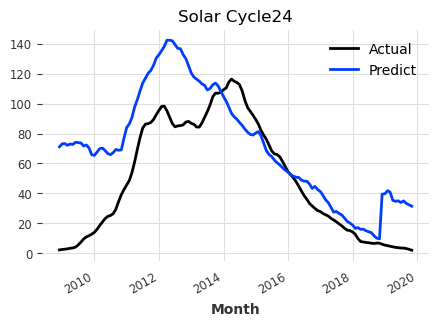

2008-12-01 00:00:00 2008-12-01 00:00:00


In [106]:
eval_model(best_model, before_series_cycle24,series_cycle24,"Solar Cycle24")

两种数据的MAE： 12.247935
两种数据的rmse： 14.581076
48 48


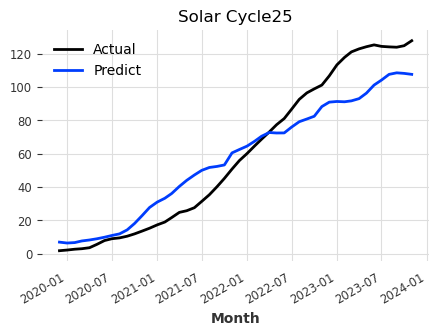

2019-12-01 00:00:00 2019-12-01 00:00:00


In [107]:
eval_model(best_model, before_series_cycle25,series_cycle25,"Solar Cycle25")

## 模型对各个活动周的拟合情况

In [88]:
def backtest(testing_model,cycle, series_cycle,title):
    # 使用两个模型计算回测预测结果
    backtest = testing_model.historical_forecasts(
        series=series_scaled,  # 输入整个序列
        start=pd.Timestamp(cycle),  # 开始时间
        forecast_horizon=output_chunk_length,  # 发出长度等于forecast_horizon的预测
        retrain=False,  # 是否重新训练模型
        verbose=True,  # 是否显示详细信息
    )
    backtest = backtest[0:len(series_cycle)]
    
    series_cycle = scaler.inverse_transform(series_cycle)
    backtest = scaler.inverse_transform(backtest)
    print("MAE:", mae(backtest,series_cycle)) 
    print("RMSE:", rmse(backtest,series_cycle))
    
    plt.figure(figsize=(5, 3))
    series_cycle.plot(label="Actual")  # 绘制实际值
    backtest.plot(label="Fitting")  # 绘制Transformer模型预测值
    plt.title(title)
    plt.legend()  
    print(len(backtest),len(series_cycle))
    print(backtest.time_index[0],series_cycle.time_index[0])

    return backtest

MAE: 9.147447
RMSE: 12.155827
137 137
1964-10-01 00:00:00 1964-10-01 00:00:00


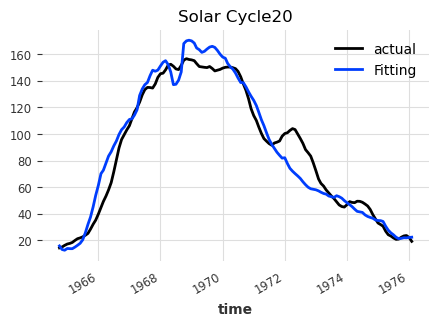

In [89]:
pred_series_cycle20 = backtest(best_model,"19541101",series_cycle20,"Solar Cycle20")  

MAE: 29.786568
RMSE: 36.69158
126 126
1976-03-01 00:00:00 1976-03-01 00:00:00


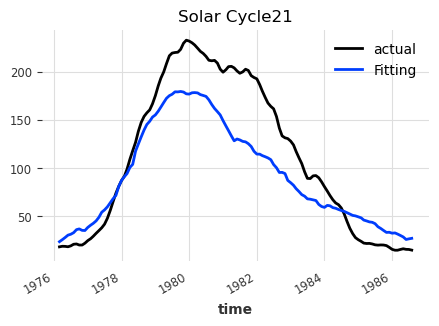

In [90]:
pred_series_cycle21 = backtest(best_model,"19660401",series_cycle21,"Solar Cycle21") 

MAE: 25.89873
RMSE: 28.65657
119 119
1986-09-01 00:00:00 1986-09-01 00:00:00


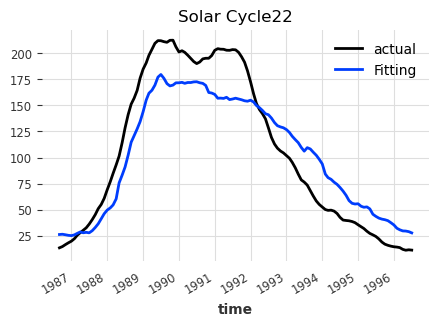

In [91]:
pred_series_cycle22 = backtest(best_model,"19761001", series_cycle22,"Solar Cycle22")

MAE: 14.481203
RMSE: 20.092684
148 148
1996-08-01 00:00:00 1996-08-01 00:00:00


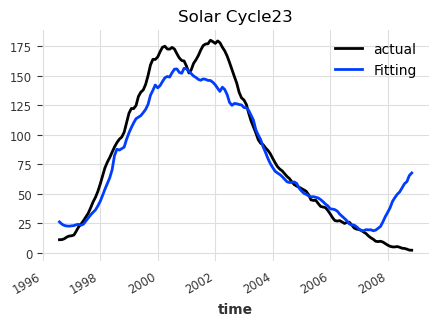

In [92]:
pred_series_cycle23 = backtest(best_model,"19860901",series_cycle23,"Solar Cycle23") 

MAE: 23.719408
RMSE: 31.72384
132 132
2008-12-01 00:00:00 2008-12-01 00:00:00


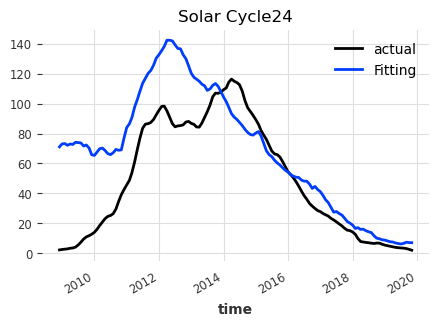

In [93]:
pred_series_cycle24 = backtest(best_model,"19990101",series_cycle24,"Solar Cycle24")

MAE: 12.325729
RMSE: 14.736324
48 48
2019-12-01 00:00:00 2019-12-01 00:00:00


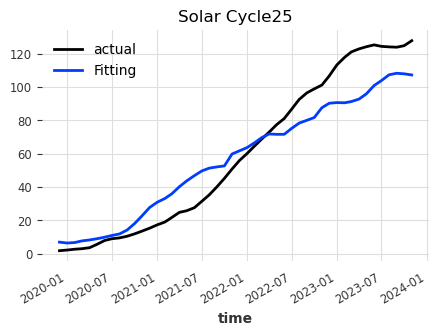

In [94]:
pred_series_cycle25 = backtest(best_model,"20100101", series_cycle25,"Solar Cycle25")

## 预测第25活动周

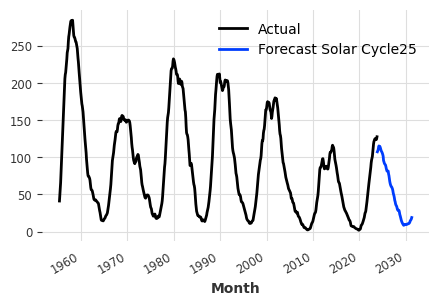

Timestamp('2023-12-01 00:00:00')

In [95]:
def predict(model, n, series,val_scaled):
    pred_series = model.predict(n=n, series= series) 
    
    pred_series = scaler.inverse_transform(pred_series)
    val_scaled = scaler.inverse_transform(val_scaled)
    
    plt.figure(figsize=(5, 3))
    val_scaled.plot(label="Actual")
    pred_series.plot(label="Forecast Solar Cycle25")
    plt.legend()
    plt.show()
    
    return pred_series
    
pred_series_cycle = predict(best_model, 90, series_scaled,val_scaled)
pred_series_cycle.time_index[0]

In [96]:
darts_to_pd = TimeSeries.pd_dataframe(pred_series_cycle) #25活动周结束于202910,

max_date = darts_to_pd['Sunspots'].idxmax() #日期
print("活动高峰期出现在：",max_date)
max_value = darts_to_pd.loc[max_date]
print("活动峰值是：",max_value['Sunspots'])

min_date = darts_to_pd['Sunspots'].idxmin() #日期
print("活动结束于：",min_date)
min_value = darts_to_pd.loc[min_date]

活动高峰期出现在： 2024-04-01 00:00:00
活动峰值是： 115.511215
活动结束于： 2029-08-01 00:00:00


In [97]:
pred_series_cycle.time_index[5]

Timestamp('2024-05-01 00:00:00')

<Axes: xlabel='Month'>

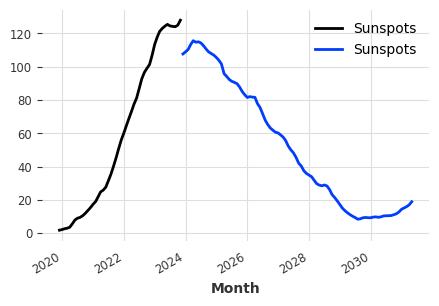

In [98]:
plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_cycle25).plot()
pred_series_cycle.plot()